In [1]:
import numpy as np
import h5py
import math
import time,sys,os
import datetime
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.units as u
import lightcone as lc
import importlib

In [58]:
importlib.reload(lc)

<module 'lightcone' from '/cosma/home/dp004/dc-boot5/Jupyter Notebooks/Order Gadget Snapshots/lightcone.py'>

In [3]:
DEBUG = True

In [118]:
# set cosmology
cosmo = FlatLambdaCDM(H0=100, Om0=0.30711520)    

In [4]:
# define particle datatype
vect = np.dtype([('x', np.float32),('y', np.float32),('z', np.float32)])
#part = np.dtype([('pos', vect),('vel', vect),('ID', np.ulonglong), ('z', np.float32), ('r', np.float32),('RA', np.float32),('Dec', np.float32)])
part = np.dtype([('pos', vect),('vel', vect),('ID', np.ulonglong)])

In [5]:
snap_path = '/cosma6/data/dp004/dc-boot5/Ordered_Snapshots/Npart_512_Box_750-Fiducial/'

In [6]:
BoxSize = 750

In [7]:
snap = 119
fnameA = snap_path + 'ordered_snapshot.snap_{0:03d}.hdf5'.format(snap)

In [8]:
with h5py.File(fnameA, 'r') as fA:
    h = fA['Header']
    NumParts = h.attrs['NumPart_Total'][1]
    zA = h.attrs['Redshift']
    pA =np.empty(fA['PartType1'].shape, dtype=part)
    fA['PartType1'].read_direct(pA)  
print('Done A, z = {0:0.3f} number of particles = {1:0d}'.format(zA,NumParts))

Done A, z = 0.079 number of particles = 134217728


In [9]:
snap = 120
fnameB = snap_path + 'ordered_snapshot.snap_{0:03d}.hdf5'.format(snap)

In [10]:
with h5py.File(fnameB, 'r') as fB:
    h = fB['Header']
    zB = h.attrs['Redshift']
    pB =np.empty(fB['PartType1'].shape, dtype=part)
    fB['PartType1'].read_direct(pB)  
print('Done B, z = {0:0.3f} '.format(zB))

Done B, z = 0.063 


In [11]:
snap = 121
fnameC = snap_path + 'ordered_snapshot.snap_{0:03d}.hdf5'.format(snap)

In [12]:
with h5py.File(fnameC, 'r') as fC:
    h = fC['Header']
    zC = h.attrs['Redshift']
    pC =np.empty(fC['PartType1'].shape, dtype=part)
    fC['PartType1'].read_direct(pC)  
print('Done C, z = {0:0.3f} '.format(zC))

Done C, z = 0.047 


In [13]:
rA = np.sqrt(pA['pos']['x']**2 + pA['pos']['y']**2 + pA['pos']['z']**2)
rB = np.sqrt(pB['pos']['x']**2 + pB['pos']['y']**2 + pB['pos']['z']**2)
rC = np.sqrt(pC['pos']['x']**2 + pC['pos']['y']**2 + pC['pos']['z']**2)

In [14]:
vA = np.sqrt(pA['vel']['x']**2 + pA['vel']['y']**2 + pA['vel']['z']**2)
vB = np.sqrt(pB['vel']['x']**2 + pB['vel']['y']**2 + pB['vel']['z']**2)
vC = np.sqrt(pC['vel']['x']**2 + pC['vel']['y']**2 + pC['vel']['z']**2)

In [15]:
vsA = np.sign(pA['vel']['x'] + pA['vel']['y'] + pA['vel']['z'])
vsB = np.sign(pB['vel']['x'] + pB['vel']['y'] + pB['vel']['z'])
vsC = np.sign(pC['vel']['x'] + pC['vel']['y'] + pC['vel']['z'])

In [16]:
vrA = vA * vsA
vrB = vB * vsB
vrC = vC * vsC

In [17]:
dx = pB['pos']['x'] - pA['pos']['x']
dy = pB['pos']['y'] - pA['pos']['y']
dz = pB['pos']['z'] - pA['pos']['z']
dr = rB - rA

In [109]:
sdr = np.sign(dr)

In [110]:
#compute snapshots where sign of particle velocity is opposite to sign of drift velocity
dsne = np.not_equal(vsB, sdr)

In [111]:
dse = np.equal(vsB, sdr)

In [112]:
vsA[vsA>0].sum(),vsA[vsA>0].sum()/vsA.size

(68295290.0, 0.5088395438429747)

In [113]:
vsA[vsA<0].sum(),vsA[vsA<0].sum()/vsA.size

(-65922440.0, -0.4911604487064447)

In [114]:
vsA.sum()

2372849.0

In [115]:
dsne.sum(), dse.sum()

(18287584, 115930145)

## Analysis
We can assume that for every particle where the drift velocity is of opposite sign to the instantaneous RMS velocity, the particle is likely to be in some form of orbital trajectory.  Assuming cosmic isotropy and homogeneity, then for each such particle, there should be an equal number of particles  in orbital trajectories where the sign of the orbital velocity and the drift velocity is the same. Hence:

In [117]:
o_frac = dsne.sum() * 2 / dsne.size
print('The proportion of particles in orbital trajectories is >= {0:0.1%}'.format(o_frac))

The proportion of particles in orbital trajectories is >= 27.3%


In [125]:
# compute delta t
delT = (cosmo.lookback_time(zA)-cosmo.lookback_time(zB)).to(u.s)
print('Time difference betwen snap A and snap B = {0:01.3e}'.format(delT))

Time difference betwen snap A and snap B = 4.558e+15 s


In [131]:
drv = (dr*u.Mpc/delT).to(u.km/u.s)

In [142]:
b = np.greater(vrA, drv.value*4)

In [143]:
b.sum()/b.size

0.4580389227119168

## Drift velocity vs particle radial velocity
For many particles not in orbital trajectories, the drift velocity between snapshots as measured by $\Delta \vec{x}$ , will be such that  $\Delta \vec{x} / \Delta t \simeq v_{RMS}$ .

Howevver, for many other particles,  $ v_{RMS}$ > $\Delta \vec{x} / \Delta t $ as shown in the histogram below.

In [156]:
vrat = vrA[1::]/drv[1::].value

/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


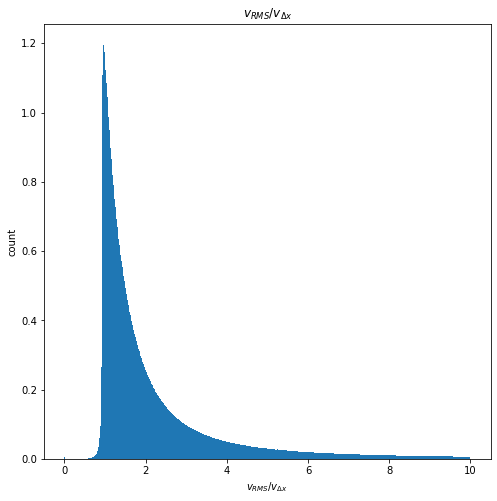

In [152]:
fi1g = plt.subplots(figsize = (8,8))
plt.hist(vrat , density=True, log=False, bins=1000, range=(0,10)) 
plt.title('$v_{RMS}/v_{\Delta x}$')
plt.xlabel('$v_{RMS}/v_{\Delta x}$')
plt.ylabel('count')
plt.show()

In [41]:
w1 = (dx>BoxSize/2) | (dy>BoxSize/2) | (dz>BoxSize/2)
w2 = (dx>BoxSize/2) & ((dy>BoxSize/2) | (dy>BoxSize/2))
w3 = (dx>BoxSize/2) & (dy>BoxSize/2) & (dy>BoxSize/2)

In [11]:
w1.sum()/NumParts * 100

0.011654943227767944

In [18]:
f = [33923867, 33923868, 34448157, 34451741, 34709265, 34713374,
       34976541, 34977052, 36018974, 36020510, 36281117, 36283166,
       36543775, 36545310, 36545823, 36546848, 36806431, 36807456,
       36807967, 36808992, 36811551, 37071135, 37332766, 37333791,
       37335318, 37593361, 53571298, 56764043, 57027722, 57027724,
       57549964, 57550476, 57814156, 57814157, 58076300, 65208101,
       65993505, 66517283, 67043101, 67306270, 67306272, 67307297,
       67307811, 67569442, 68090657, 70924054]

In [19]:
pA1 = pA[f]
pB1 = pB[f]
pC1 = pC[f]

In [20]:
pA1['vel'][0],pB1['vel'][0],pC1['vel'][0]

((-2781.9734, 75.44845, -222.12311),
 (-3175.7424, 178.14557, -92.94676),
 (-2431.0947, 91.73712, 149.1299))

In [21]:
pA1['pos'][0],pB1['pos'][0],pC1['pos'][0]

((193.95503, 304.02002, 403.43344),
 (193.45178, 304.044, 403.40118),
 (193.02272, 304.06314, 403.41))

In [59]:
WL = lc.WorldLine(zA, zB)

In [60]:
WL.zzA, WL.zzB

(0.07940147675228881, 0.06303216697298986)

In [61]:
WL.chiA, WL.chiB

(<Quantity 233.62199582 Mpc>, <Quantity 186.18935882 Mpc>)

In [62]:
WL.Tbar, WL.delT

(<Quantity 0.66119962 Gyr>, <Quantity 0.14442377 Gyr>)

In [93]:
WL.set_A(pA1[1])

In [94]:
WL.set_B(pB1[1])

In [95]:
WL.calc_pos_mean_delta()

In [96]:
WL.calc_vel_mean_delta()

In [97]:
WL.set_offset(0,0,0)

In [98]:
WL.test_lightcone_crossing()

1

In [99]:
tLB = WL.get_lightcone_intersection()

icount:= 1, tLB:= 0.6612 Gyr, zz:= 0.0712, chiLC:= 209.8, Rad:= 196.4, RadDiff:= 13.37
icount:= 2, tLB:= 0.6251 Gyr, zz:= 0.0671, chiLC:= 198.0, Rad:= 196.7, RadDiff:= 1.28
icount:= 3, tLB:= 0.6070 Gyr, zz:= 0.0651, chiLC:= 192.1, Rad:= 196.6, RadDiff:= -4.56
icount:= 4, tLB:= 0.6161 Gyr, zz:= 0.0661, chiLC:= 195.0, Rad:= 196.7, RadDiff:= -1.66
icount:= 5, tLB:= 0.6206 Gyr, zz:= 0.0666, chiLC:= 196.5, Rad:= 196.7, RadDiff:= -0.20
icount:= 6, tLB:= 0.6228 Gyr, zz:= 0.0668, chiLC:= 197.2, Rad:= 196.7, RadDiff:= 0.54
icount:= 7, tLB:= 0.6217 Gyr, zz:= 0.0667, chiLC:= 196.9, Rad:= 196.7, RadDiff:= 0.17
icount:= 8, tLB:= 0.6211 Gyr, zz:= 0.0666, chiLC:= 196.7, Rad:= 196.7, RadDiff:= -0.01
icount:= 9, tLB:= 0.6214 Gyr, zz:= 0.0667, chiLC:= 196.8, Rad:= 196.7, RadDiff:= 0.08
icount:= 10, tLB:= 0.6213 Gyr, zz:= 0.0667, chiLC:= 196.7, Rad:= 196.7, RadDiff:= 0.03
icount:= 11, tLB:= 0.6212 Gyr, zz:= 0.0667, chiLC:= 196.7, Rad:= 196.7, RadDiff:= 0.01
icount:= 12, tLB:= 0.6212 Gyr, zz:= 0.0666, chi

In [100]:
WL.rad

196.69961547851562

In [101]:
WL.Pos['x'].item()

-181.2542266845703

In [102]:
WL.dec

8.25085735321045

In [73]:
WL.Pos[0]

(-181.59157, -70.96433, 28.375883)

In [74]:
WL.Vel[0]

(-624.22144, 22.0243, -118.88899)

In [88]:
WL.mode = 'cubic'

In [103]:
WL.mode

'cubic'

In [75]:
pA1[0]

((193.95503, 304.02002, 403.43344), (-2781.9734, 75.44845, -222.12311), 33923867)

In [96]:
o = np.array([375])

In [97]:
o.astype(vect)

array([(375., 375., 375.)],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')])

In [100]:
pB1['pos']['x'][0]- 375, pA1['pos']['x'][0]- 375 

(-181.5482177734375, -181.0449676513672)

In [ ]:
pB1['pos']['x'][0]- 375

In [76]:
T = np.linspace(WL.tLB_A, WL.tLB_B, 100)

In [104]:
pos = np.empty(100, dtype = vect)
vel = np.empty(100, dtype = vect)
v_rms =  np.empty(100, dtype = np.float32)
v_rad =  np.empty(100, dtype = np.float32)
r = np.empty(100, np.float32)
for i,t in enumerate(T):
    r[i] = WL.get_world_line(t)
    pos[i] = WL.Pos.item()
    vel[i] = WL.Vel.item()
    v_rms[i] = np.sqrt(vel['x'][i]**2 + vel['y'][i]**2 + vel['z'][i]**2)
    v_rad[i] = v_rms[i] *  np.sign(vel['x'][i] + vel['y'][i] + vel['z'][i])

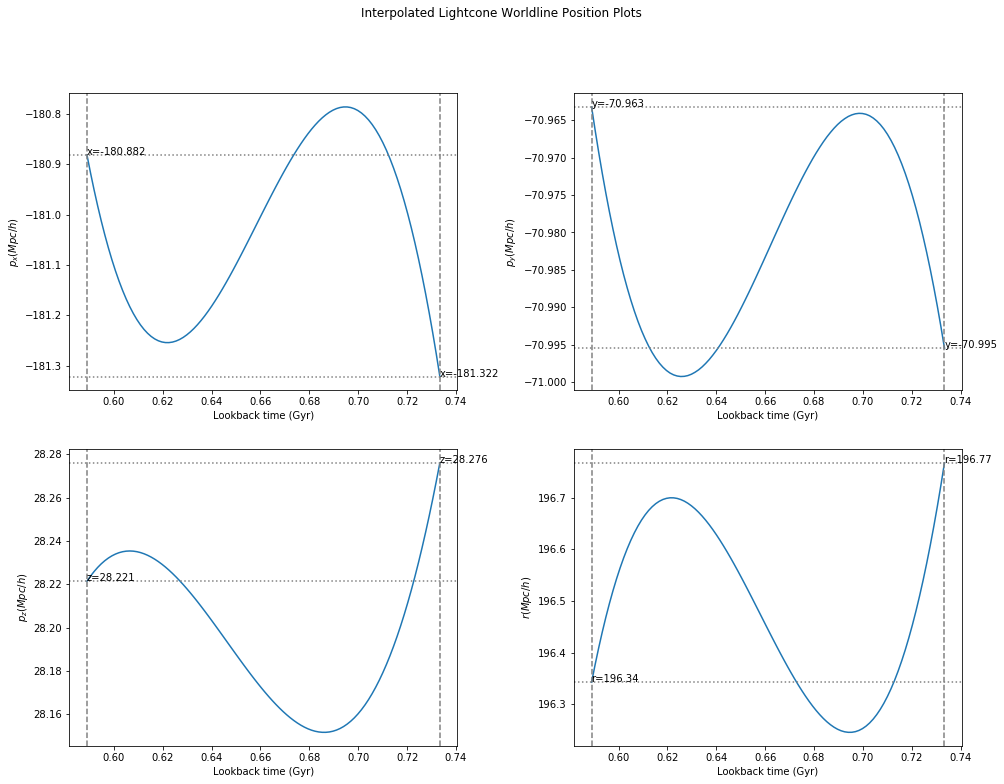

In [105]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(wspace = 0.3)
ax1.plot(T, pos['x'])
ax2.plot(T, pos['y'])
ax3.plot(T, pos['z'])
ax4.plot(T, r)
ax1.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax1.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')
ax2.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax2.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')
ax3.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax3.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')
ax4.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax4.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')

ax1.axhline(y=pos['x'][0], color = 'grey', linestyle = ':')
ax1.axhline(y=pos['x'][-1], color = 'grey', linestyle = ':')
ax2.axhline(y=pos['y'][0], color = 'grey', linestyle = ':')
ax2.axhline(y=pos['y'][-1], color = 'grey', linestyle = ':')
ax3.axhline(y=pos['z'][0], color = 'grey', linestyle = ':')
ax3.axhline(y=pos['z'][-1], color = 'grey', linestyle = ':')
ax4.axhline(y=r[0], color = 'grey', linestyle = ':')
ax4.axhline(y=r[-1], color = 'grey', linestyle = ':')

ax1.text(WL.tLB_A.value, pos['x'][0], 'x={0:0.3f}'.format(pos['x'][0]),fontsize=10)
ax1.text(WL.tLB_B.value, pos['x'][-1],'x={0:0.3f}'.format(pos['x'][-1]),fontsize=10)
ax2.text(WL.tLB_A.value, pos['y'][0], 'y={0:0.3f}'.format(pos['y'][0]),fontsize=10)
ax2.text(WL.tLB_B.value, pos['y'][-1],'y={0:0.3f}'.format(pos['y'][-1]),fontsize=10)
ax3.text(WL.tLB_A.value, pos['z'][0], 'z={0:0.3f}'.format(pos['z'][0]),fontsize=10)
ax3.text(WL.tLB_B.value, pos['z'][-1],'z={0:0.3f}'.format(pos['z'][-1]),fontsize=10)
ax4.text(WL.tLB_A.value, r[0], 'r={0:0.2f}'.format(r[0]),fontsize=10)
ax4.text(WL.tLB_B.value, r[-1],'r={0:0.2f}'.format(r[-1]),fontsize=10)

ax1.set_xlabel('Lookback time (Gyr)')
ax2.set_xlabel('Lookback time (Gyr)')
ax3.set_xlabel('Lookback time (Gyr)')
ax4.set_xlabel('Lookback time (Gyr)')
ax1.set_ylabel('$p_x (Mpc/h)$')
ax2.set_ylabel('$p_y (Mpc/h)$')
ax3.set_ylabel('$p_z (Mpc/h)$')
ax4.set_ylabel('$r (Mpc/h)$')
fig.suptitle('Interpolated Lightcone Worldline Position Plots')
#plt.legend()
plt.savefig('WL_pos_plot.png')
plt.show()

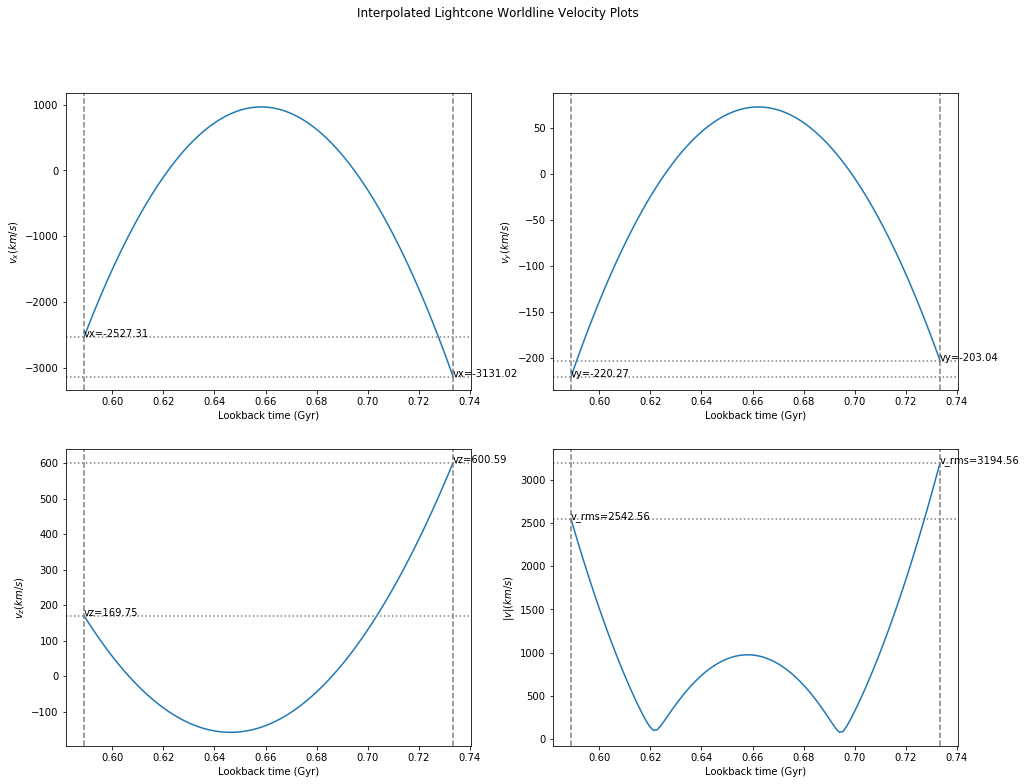

In [106]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2,figsize=(16,12))
ax1.plot(T, vel['x'])
ax2.plot(T, vel['y'])
ax3.plot(T, vel['z'])
ax4.plot(T, v_rms)
ax1.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax1.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')
ax2.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax2.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')
ax3.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax3.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')
ax4.axvline(x=WL.tLB_A.value, color = 'grey', linestyle = '--')
ax4.axvline(x=WL.tLB_B.value, color = 'grey', linestyle = '--')

ax1.axhline(y=vel['x'][0], color = 'grey', linestyle = ':')
ax1.axhline(y=vel['x'][-1], color = 'grey', linestyle = ':')
ax2.axhline(y=vel['y'][0], color = 'grey', linestyle = ':')
ax2.axhline(y=vel['y'][-1], color = 'grey', linestyle = ':')
ax3.axhline(y=vel['z'][0], color = 'grey', linestyle = ':')
ax3.axhline(y=vel['z'][-1], color = 'grey', linestyle = ':')
ax4.axhline(y=v_rms[0], color = 'grey', linestyle = ':')
ax4.axhline(y=v_rms[-1], color = 'grey', linestyle = ':')

ax1.text(WL.tLB_A.value, vel['x'][0], 'vx={0:0.2f}'.format(vel['x'][0]),fontsize=10)
ax1.text(WL.tLB_B.value, vel['x'][-1],'vx={0:0.2f}'.format(vel['x'][-1]),fontsize=10)
ax2.text(WL.tLB_A.value,vel['y'][0], 'vy={0:0.2f}'.format(vel['y'][0]),fontsize=10)
ax2.text(WL.tLB_B.value, vel['y'][-1],'vy={0:0.2f}'.format(vel['y'][-1]),fontsize=10)
ax3.text(WL.tLB_A.value, vel['z'][0], 'vz={0:0.2f}'.format(vel['z'][0]),fontsize=10)
ax3.text(WL.tLB_B.value, vel['z'][-1],'vz={0:0.2f}'.format(vel['z'][-1]),fontsize=10)
ax4.text(WL.tLB_A.value, v_rms[0], 'v_rms={0:0.2f}'.format(v_rms[0]),fontsize=10)
ax4.text(WL.tLB_B.value, v_rms[-1],'v_rms={0:0.2f}'.format(v_rms[-1]),fontsize=10)

ax1.set_xlabel('Lookback time (Gyr)')
ax2.set_xlabel('Lookback time (Gyr)')
ax3.set_xlabel('Lookback time (Gyr)')
ax4.set_xlabel('Lookback time (Gyr)')
ax1.set_ylabel('$v_x (km/s)$')
ax2.set_ylabel('$v_y (km/s)$')
ax3.set_ylabel('$v_z (km/s)$')
ax4.set_ylabel('$\|v\| (km/s)$')
fig.suptitle('Interpolated Lightcone Worldline Velocity Plots')
plt.savefig('WL_vel_plot.png')
plt.show()

In [36]:
delT = WL.tLB_A - WL.tLB_B

In [72]:
dt = delT.to(u.s)

In [58]:
dp = np.sqrt(dx*dx+dy*dy+dz*dz)*u.Mpc

In [68]:
dp = dp.to(u.km)

In [69]:
dp[:10]

<Quantity [0.0000000e+00, 2.0316204e+18, 1.9328621e+18, 1.8696623e+18,
           1.9014665e+18, 1.8439281e+18, 1.7219812e+18, 1.6283261e+18,
           1.4884470e+18, 1.3718572e+18] km>

In [51]:
H0 = 100 * u.km / u.s /u.Mpc

In [52]:
H0

<Quantity 100. km / (Mpc s)>

In [47]:
v  = np.sqrt((pA['vel']['x']**2 + pA['vel']['y']**2 + pA['vel']['z']**2)*(1+zA))

In [74]:
v_eff = dp/dt

In [75]:
v_eff[:10]

<Quantity [  0.     , 445.75882, 424.0902 , 410.2235 , 417.2017 ,
           404.57718, 377.8207 , 357.27182, 326.58087, 300.99985] km / s>

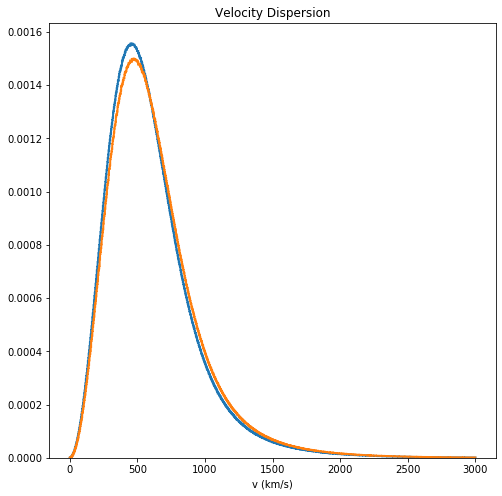

In [81]:
fig = plt.subplots(figsize = (8,8))
plt.hist(v , density=True, log=False, bins=1000, histtype='step', linewidth = 2, range = (0,3000)) 
plt.hist(v_eff , density=True, log=False, bins=1000, histtype='step', linewidth = 2, range = (0,3000)) 
plt.title('Velocity Dispersion')
plt.xlabel('v (km/s)')
plt.show()

In [59]:
dp.size

134217729

In [60]:
f = tuple([(dx<BoxSize/2) & (dy<BoxSize/2) & (dz<BoxSize/2)])

In [43]:
f = tuple([(dx<BoxSize/2)])

In [69]:
dp2=dp[dp<BoxSize/2]

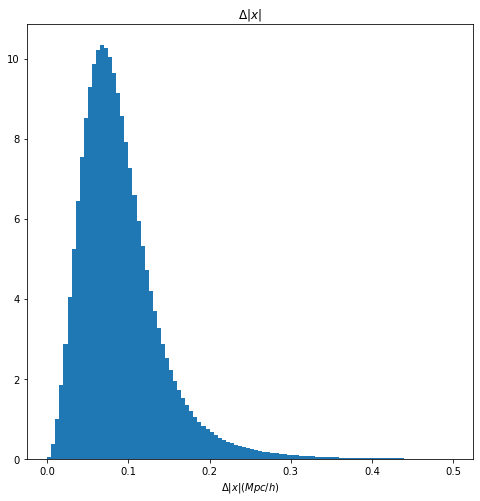

In [76]:
fi1g = plt.subplots(figsize = (8,8))
plt.hist(dp2 , density=True, log=False, bins=100, range=(0,0.5)) 
plt.title('$\Delta \|x\|$')
plt.xlabel('$\Delta \|x\| (Mpc/h)$')
plt.show()

In [94]:
zz = np.empty(0,np.float32)
v_avg = np.empty(0,np.float32)
v_max = np.empty(0,np.float32)
for snap in range(88,127):
    fname = snap_path + 'ordered_snapshot.snap_{0:03d}.hdf5'.format(snap)
    # Check that file actually exists for this snapshot
    if os.path.exists(fname):
        with h5py.File(fname,'r') as f:
            h = f['Header']
            z = h.attrs['Redshift']
            zz=np.append(zz, z)
            a = 1/(1+z)
            p =  f['PartType1']
            v  = np.sqrt((p['vel']['x']**2 + p['vel']['y']**2 + p['vel']['z']**2)/a)
            v_max=np.append(v_max, np.amax(v))
            v_avg=np.append(v_avg, np.mean(v))
        print('Done snapshot {0:d}'.format(snap))
    else:
        print('Snapshot file {0:d} does not exist'.format(snap))

Done snapshot 88
Done snapshot 89
Done snapshot 90
Done snapshot 91
Done snapshot 92
Done snapshot 93
Done snapshot 94
Done snapshot 95
Done snapshot 96
Done snapshot 97
Done snapshot 98
Done snapshot 99
Done snapshot 100
Done snapshot 101
Done snapshot 102
Done snapshot 103
Done snapshot 104
Done snapshot 105
Done snapshot 106
Done snapshot 107
Done snapshot 108
Done snapshot 109
Done snapshot 110
Done snapshot 111
Snapshot file 112 does not exist
Done snapshot 113
Done snapshot 114
Done snapshot 115
Done snapshot 116
Done snapshot 117
Snapshot file 118 does not exist
Done snapshot 119
Done snapshot 120
Done snapshot 121
Snapshot file 122 does not exist
Done snapshot 123
Done snapshot 124
Snapshot file 125 does not exist
Done snapshot 126


In [97]:
v_avg

array([687.8734 , 686.5518 , 683.67365, 682.0966 , 680.43494, 676.8422 ,
       674.91486, 672.9008 , 670.8047 , 668.6275 , 666.35223, 661.5158 ,
       658.9596 , 656.3317 , 653.6411 , 650.8611 , 647.97766, 644.9942 ,
       641.9216 , 638.7592 , 635.5153 , 632.18567, 628.7474 , 625.19434,
       621.5297 , 617.7696 , 613.92664, 610.0215 , 606.0473 , 602.0024 ,
       597.88873, 593.7114 , 589.487  , 585.1984 , 580.8371 ],
      dtype=float32)

In [95]:
v_max[::]

array([5925.716 , 5681.769 , 5837.801 , 6218.5244, 6118.392 , 6324.3857,
       6141.365 , 5984.8755, 5704.4946, 5804.118 , 5995.9595, 5843.292 ,
       5864.2607, 5530.1855, 5314.2183, 5626.409 , 5645.7812, 5924.0527,
       7027.8096, 6762.0986, 6282.897 , 5882.4526, 5849.606 , 5644.5674,
       5758.925 , 5469.928 , 5464.0415, 5717.2256, 5420.1885, 5537.8047,
       5262.063 , 5271.9326, 5756.2876, 5767.1787, 5947.253 ],
      dtype=float32)

In [96]:
zz

array([7.60168556e-01, 7.33475296e-01, 6.81297061e-01, 6.55799900e-01,
       6.30689409e-01, 5.81605066e-01, 5.57619752e-01, 5.33998180e-01,
       5.10734832e-01, 4.87824278e-01, 4.65261166e-01, 4.21156273e-01,
       3.99604193e-01, 3.78378953e-01, 3.57475598e-01, 3.36889247e-01,
       3.16615090e-01, 2.96648395e-01, 2.76984498e-01, 2.57618808e-01,
       2.38546802e-01, 2.19764025e-01, 2.01266093e-01, 1.83048686e-01,
       1.65107548e-01, 1.47438491e-01, 1.30037388e-01, 1.12900176e-01,
       9.60228526e-02, 7.94014768e-02, 6.30321670e-02, 4.69111006e-02,
       3.10345130e-02, 1.53986966e-02, 2.22044605e-16])

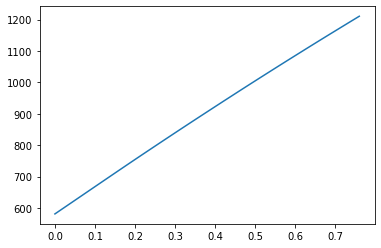

In [126]:
plt.plot(zz, v_avg*(1+zz))
#plt.plot(zz, v_max)
plt.show()

In [100]:
cosmo.lookback_time([0.031, 0.015])

<Quantity [0.43750446, 0.21416201] Gyr>

In [32]:
v = 3000* u.km/u.s

In [33]:
v

<Quantity 3000. km / s>

In [39]:
t = 0.14 * u.Gyr

In [40]:
t

<Quantity 0.14 Gyr>

In [41]:
d = v*t

In [42]:
d

<Quantity 420. Gyr km / s>

In [43]:
d.to(u.Mpc)

<Quantity 0.42953911 Mpc>

In [44]:
v = 500* u.km/u.s

In [70]:
828000 /3600

230.0

In [2]:
16*24/60

6.4